<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 2:</span> MODELLING STACKOVERFLOW QUESTIONS TAGS</h1>

In this module, we'll cover:
1. [Import modules and load data](#modules)
2. [Supervised Machine learning models](#supervised)<br>
    2.1. [MultinomialNB](#nb)<br>
    2.2. [LinearSVC](#svc)<br>
    2.3. [Logistic Reg](#log)<br>
    2.3. [Predict tags](#tags_s)<br>

3. [Supervised Machine learning models](#unsupervised)<br>
    3.1. [Clustering KMEANS](#kmeans)<br>
    3.2. [Model training](#train)<br>
    3.3. [Predict tags](#tags_u)<br>
 
4. [Comparison between Supervised and unsupervised Machine learning models](#comparison)
<hr>

<span id="modules"></span>
## 1. Import modules and load data

In [1]:
import pandas as pd
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.mixture import GMM
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joël\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [3]:
tic()
data_df=pd.read_csv('StackOverflow_7.csv')
data_df.head()
tac()

Time passed: 0hour:0min:13sec


In [4]:
data_df.columns

Index(['Unnamed: 0', 'Id', 'CreationDate', 'Score', 'Body', 'Title', 'Tags',
       'Body_whtml', 'Tags_', 'Body_word_count', 'Title_word_count',
       'Tags_word_count', 'Title_body', 'Tags_plus', 'clean_word',
       'Tags_final', '.net', 'actionscript-3', 'ajax', 'algorithm', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa',
       'cocoa-touch', 'css', 'database', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'excel', 'flash', 'flex',
       'html', 'iis', 'internet-explorer', 'iphone', 'java', 'javascript',
       'jquery', 'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'versi

In [5]:
data_df=data_df.head(10000)

In [6]:
df_tags = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1)

In [7]:
df_tags.columns

Index(['.net', 'actionscript-3', 'ajax', 'algorithm', 'apache', 'arrays',
       'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'cocoa', 'cocoa-touch',
       'css', 'database', 'debugging', 'delphi', 'design', 'design-patterns',
       'django', 'eclipse', 'excel', 'flash', 'flex', 'html', 'iis',
       'internet-explorer', 'iphone', 'java', 'javascript', 'jquery',
       'language-agnostic', 'linq', 'linq-to-sql', 'linux', 'macos',
       'multithreading', 'mysql', 'nhibernate', 'objective-c', 'oop', 'oracle',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'silverlight', 'sql',
       'sql-server', 'sql-server-2005', 'string', 'svn', 'tsql',
       'unit-testing', 'user-interface', 'vb.net', 'version-control',
       'visual-studio', 'visual-studio-2008', 'wcf', 'web-services', 'winapi',
       'windows', 'winforms', 'wpf', 'xml'],
      dtype='object')

<span id="supervised"></span>
## 2. Supervised Machine learning models
   2.1. [MultinomialNB](#nb)<br>
   2.2. [LinearSVC](#svc)<br>
   2.3. [Logistic Reg](#log)<br>
   2.3. [Predict tags](#tags_s)

In [8]:
# split the data, leave 1/5 out for testing
tic()
data_x = data_df[['clean_body']]
data_y = data_df.drop(['Tags_final', 'clean_word', 'Tags_plus','Title_body', 'Tags_word_count',
                      'Title_word_count','Body_word_count', 'Tags_', 'Body_whtml', 'Tags',
                      'Title', 'Body', 'Score', 'CreationDate', 'Id', 'Unnamed: 0','Tags_total',
                      'clean_body'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data_x,data_y, test_size=0.2, random_state=42)

x_train_1=x_train.as_matrix()
x_test_1=x_test.as_matrix()

y_train_1=y_train.as_matrix()
y_test_1=y_test.as_matrix()

# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train_1.tolist()]
test_x = [x[0].strip() for x in x_test_1.tolist()]
tac()

Time passed: 0hour:0min:0sec


<span id="nb"></span>
## 2.1. MultinomialNB

In [32]:
tic()
stop_words = set(stopwords.words("english"))
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters_1 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}
grid_search_tune_1 = GridSearchCV(pipeline_1, parameters_1, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_1.fit(train_x, y_train_1)
print (grid_search_tune_1.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_1 = grid_search_tune_1.best_estimator_
predictions_1 = best_clf_1.predict(test_x)

print (classification_report(y_test_1, predictions_1,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.6min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True),
          n_jobs=1))]
Applying best classifie

<span id="svc"></span>
## 2.2. LinearSVC

In [33]:
tic()
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC())),
])

parameters_2 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_2 = GridSearchCV(pipeline_2, parameters_2, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_2.fit(train_x, y_train_1)
print (grid_search_tune_2.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_2 = grid_search_tune_2.best_estimator_
predictions_2 = best_clf_2.predict(test_x)

print (classification_report(y_test_1, predictions_2,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  7.1min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squa

<span id="log"></span>
## 2.3. Logistic Reg

In [34]:
tic()
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])
parameters_3 = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

grid_search_tune_3 = GridSearchCV(pipeline_3, parameters_3, cv=2, n_jobs=-1, verbose=3)
grid_search_tune_3.fit(train_x, y_train_1)
print (grid_search_tune_3.best_estimator_.steps)

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf_3 = grid_search_tune_3.best_estimator_
predictions_3 = best_clf_3.predict(test_x)

print (classification_report(y_test_1, predictions_3,target_names=df_tags.columns))
tac()

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 59.8min finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'can', 'until', 'we', 'yourself', 'hadn', 'here', 'any', 'than', 'll', "that'll", 'her', 'hasn', 'but', 'their', "haven't", 'wouldn', 't', 'into', 'weren', "shan't", 'and', 'while', 'my', 'ourselves', 'were', 'the', 'mustn', "hadn't", 'being', 've', 'whom', 'itself', 'mightn', "mightn't"...', 'aren', 'there', 'if', 'above', 'few', 'when', "mustn't", 'didn', "shouldn't", 'before', 'needn'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scal

<span id="tags_s"></span>
## 2.3. Predict tags

In [35]:
from sklearn.externals import joblib
joblib.dump(grid_search_tune_2.best_estimator_, 'linearSVC_1.pkl',compress=3)

['linearSVC_1.pkl']

In [39]:
linear_SVC = joblib.load('linearSVC_1.pkl')

In [37]:
most_freq_w=['using','like', 'im', 'would', 'use', 'code', 'get', 'way', 'new', 'want']
less_feq_w=['efdestroyworksheetws', 'jltmatrix0length', 'offltagtltligtthis','postmessagemyprojectentitiesbetmessage',
           'columnsfooter', 'omittednote', 'classestaskm95720090413', 'httpossoetikerchrrdtoo', 'addcontrolstolistccontrols',
           'dofollowuplots']

In [38]:
def clean_p(text):
    text = " ".join(x.lower() for x in text.split() ) 
    text=re.sub('[^\w\s]', "", text)
    text=re.sub(re.escape('?'), "", text)
    stop = stopwords.words('english')
    text = " ".join(x for x in text.split() if x not in stop)
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    return(text)

In [40]:
def predict_SU_(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(df_tags.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(df_tags.columns[i])
    tags_="".join('<'+x+'>' for x in tags)
    return tags_

In [49]:
def predict_SU_S(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(df_tags.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(df_tags.columns[i])
    tags_=" ".join(x for x in tags)
    return tags_

In [43]:
x_test.head()

,clean_body
6252,error serializing string webservice call morni...
4684,database system relational types database syst...
1731,set test cert ssl connection net create ssl co...
4742,killing excelexe server possible duplicate pro...
4521,apache rewrite based subdomain trying redirect...


In [47]:
predict_SU_(x_test['clean_body'][4684])

'<database>'

In [48]:
data_df['Tags'][4684]

'<database>'

<span id="unsupervised"></span>
## 3. Unsupervised (Latent Dirichlet Allocation-LDA)

In [9]:
most_freq_w=['using','like', 'im', 'would', 'use', 'code', 'get', 'way', 'new', 'want']
less_feq_w=['efdestroyworksheetws', 'jltmatrix0length', 'offltagtltligtthis','postmessagemyprojectentitiesbetmessage',
           'columnsfooter', 'omittednote', 'classestaskm95720090413', 'httpossoetikerchrrdtoo', 'addcontrolstolistccontrols',
           'dofollowuplots']

In [10]:
def dote(a):
    a=a.group(0)
    a=re.sub("\.", "dote", a)
    return a

In [11]:
def clean_1(text):
    text=re.sub(r"http\S+", "", text)
    text = re.sub("#", "hash", text)
    text = re.sub("-", "menos", text)
    text = re.sub(r"\.[a-zA-Z0-9]+",dote, text)
    text=re.sub(re.escape('++'), 'plus', text)
    text=re.sub(re.escape('?'), '', text)
    text=re.sub(r'[^\w\s]','',text)
    text=re.sub(r' +[0-9]+ ','',text)
    words = text.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = " ".join(w for w in words if not w in stops)
    meaningful_words = " ".join(w for w in meaningful_words.split() if not w in most_freq_w)
    meaningful_words = " ".join(w for w in meaningful_words.split() if not w in less_feq_w)
    return(meaningful_words)

In [12]:
tic()
data_df['clean_words_']=data_df['Title_body'].apply(lambda x:clean_1(str(x)))
tac()

Time passed: 0hour:0min:4sec


In [13]:
data_df['clean_words_'][0]

'convert decimal double trackmenosbar change forms opacitydotethis codedecimal trans trackbar1dotevalue 5000thisdoteopacity transwhen build application gives following error cannot implicitly convert type decimal doubledotei tried trans double control doesnt work worked fine past vbdotenet project'

In [14]:
x_train_add=x_train.reset_index()
x_train_lda=data_df.iloc[x_train_add['index'].tolist()][['clean_body']]
x_train_lda.head()

,clean_body
9254,javascript repository many languages standard ...
1561,io permission settings net installer creating ...
1670,best encapsulate complex oracle plsql cursor l...
6087,databases permissions find databases minimum r...
6669,achieve 100 decoupling achieve 100 decoupling ...


In [16]:
import gensim

In [17]:
# Convert to list
data = x_train_lda.clean_body.values.tolist()

In [24]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['javascript', 'repository', 'many', 'languages', 'standard', 'repositories', 'people', 'donate', 'useful', 'libraries', 'others', 'access', 'instance', 'perl', 'cpan', 'php', 'pear', 'ruby', 'rubygems', 'best', 'option', 'javascripti', 'ask', 'months', 'ago', 'ported', 'perl', 'javascript', 'say', 'ported', 'mean', 'ran', 'text', 'substitutions', 'fixed', 'things', 'hand', 'rewrite', 'since', 'ive', 'used', 'module', 'number', 'times', 'perl', 'figure', 'likely', 'useful', 'someone', 'ive', 'put', 'open', 'source', 'license', 'original', 'choice', 'gpl', 'artistic', 'license', 'idea', 'put', 'people', 'might', 'likely', 'find', 'itit', 'doesnt', 'fit', 'sort', 'framework', 'standalone', 'library', 'gives', 'ability', 'calculate', 'number', 'useful', 'statistics', 'distributions', 'digits', 'accuracy', 'javascript']]


In [27]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = " ".join(sent)
        texts_out.append(doc)
    return texts_out


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['javascript repository many languages standard repositories people donate useful libraries others access instance perl cpan php pear ruby rubygems best option javascripti ask months ago ported perl javascript say ported mean ran text substitutions fixed things hand rewrite since ive used module number times perl figure likely useful someone ive put open source license original choice gpl artistic license idea put people might likely find itit doesnt fit sort framework standalone library gives ability calculate number useful statistics distributions digits accuracy javascript', 'io permission settings net installer creating program installed net installer project program writes settings files directory program files dir believe active directory settings prevent application righting directory limited user running program away change settings application folder install problem']


In [28]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [29]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [31]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -2256487.4487524745
Perplexity:  1602.5106113372335
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 20, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [32]:
tic()
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
tac()

Time passed: 0hour:13min:46sec


In [33]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -776703.6779317061
Model Perplexity:  1513.4939129455458


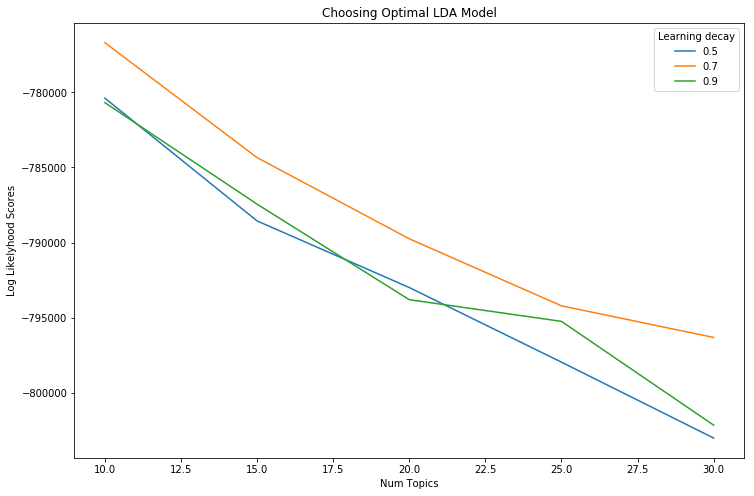

In [34]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [133]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(0,10)]

# index names
docnames = ["Quest" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Quest0,0.42,0.39,0.07,0.02,0.07,0,0,0.03,0,0,0
Quest1,0,0,0,0,0,0.95,0.03,0,0,0,5
Quest2,0,0.26,0,0,0.73,0,0,0,0,0,4
Quest3,0.01,0.69,0.01,0.01,0.25,0.01,0.01,0.01,0.01,0.01,1
Quest4,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0
Quest5,0.01,0.01,0.01,0.01,0.95,0.01,0.01,0.01,0.01,0.01,4
Quest6,0.23,0.08,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.65,9
Quest7,0.01,0.01,0.01,0.01,0.01,0.36,0.01,0.01,0.58,0.01,8
Quest8,0.07,0,0,0,0,0,0,0,0.91,0,8
Quest9,0,0.9,0,0,0,0,0,0,0,0.08,1


In [48]:
df_document_topic.shape

(8000, 11)

In [196]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts(sort=True).reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,2163
1,4,1272
2,9,1189
3,1,1179
4,7,539
5,8,464
6,5,379
7,6,367
8,2,326
9,3,122


In [38]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abc,ability,able,abort,absolute,absolutely,abstract,abstraction,accept,acceptable,...,yield,youd,youll,youre,youve,yui,zend,zero,zip,zone
Topic0,0.100012,43.363106,249.603228,0.100013,0.100015,0.100035,0.100015,0.100038,11.977913,0.100045,...,0.100018,0.100041,11.622285,36.777242,32.044417,0.100008,0.100023,0.100031,0.100013,0.100009
Topic1,0.100011,20.497709,66.070251,0.100014,0.100018,0.100015,0.100019,0.100028,0.100065,16.943910,...,0.100014,0.100042,0.100017,0.145686,0.100007,14.750275,0.100120,4.969764,0.100016,0.100011
Topic2,0.100127,0.100025,0.101185,0.100050,0.100012,0.100027,0.100017,3.324112,0.100032,5.737303,...,0.100019,0.106050,0.100030,0.100031,0.100042,0.100005,0.100057,0.100042,0.100022,0.100008
Topic3,0.100008,0.100025,6.357823,0.100002,23.796684,0.100025,0.100006,0.100041,0.100020,0.100072,...,0.100005,0.100030,0.100035,0.100024,0.100012,0.100008,0.100011,0.100035,0.100013,0.100011
Topic4,16.766477,0.100032,262.782461,0.100060,18.268647,17.080755,0.100008,0.100040,34.252796,0.100038,...,13.968765,11.138220,0.146341,16.726461,0.100010,0.100018,0.100013,0.100058,0.100019,24.634588


In [39]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,good,file,files,best,know,ive,looking,windows,library,source,java,need,net,really,used
Topic 1,sql,database,data,server,table,aspnet,page,web,query,site,stored,need,user,tables,column
Topic 2,error,exception,message,type,ruby,rails,send,following,email,line,print,match,messages,foo,perl
Topic 3,array,memory,list,items,collection,performance,tags,algorithm,order,join,left,hash,tab,right,attributes
Topic 4,time,problem,need,work,ive,update,end,user,set,know,list,bit,dont,date,doesnt
Topic 5,application,net,version,server,directory,process,files,log,user,folder,running,path,machine,install,program
Topic 6,visual,studio,web,project,build,service,run,server,eclipse,projects,start,running,application,report,solution
Topic 7,text,control,form,page,javascript,html,event,controls,content,button,css,user,tag,field,jquery
Topic 8,file,xml,windows,application,app,window,image,custom,create,open,document,wpf,connection,web,net
Topic 9,class,string,object,return,method,public,test,function,value,int,objects,null,type,static,classes


In [136]:
np.array(vectorizer.get_feature_names())

array(['abc', 'ability', 'able', ..., 'zero', 'zip', 'zone'], dtype='<U15')

In [161]:
def predict_topic(text):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = 'Topic_'+str(int(df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].dominant_topic))
    return topic

In [162]:
predict_topic(data_df['clean_body'][9575])

'Topic_0'

In [43]:
x_test['clean_body'][6252]

'error serializing string webservice call morning ran issue returning back text string result web service call error getting exception text systemservicemodelcommunicationexception error deserializing body reply message operation getfilingtreexml gt systeminvalidoperationexception error xml document 1 9201 gt systemxmlxmlexception maximum string content length quota 8192 exceeded reading xml data quota may increased changing maxstringcontentlength property xmldictionaryreaderquotas object used creating xml reader line 1 position 9201at systemxmlxmlexceptionhelperthrowxmlexceptionxmldictionaryreader reader string res string arg1 string arg2 string arg3at systemxmlxmlexceptionhelperthrowmaxstringcontentlengthexceededxmldictionaryreader reader int32 maxstringcontentlengthat systemxmlxmldictionaryreaderreadstringint32 maxstringcontentlengthat systemxmlxmldictionaryreaderreadstringat systemxmlxmlbasereaderreadelementstringat microsoftxmlserializationgeneratedassemblyxmlserializationreaderim

In [46]:
data_df['Tags'][6252]

'<web-services><xmlreader><maxstringcontentlength>'

In [50]:
y_train_add_=y_train.reset_index()
df_document_topic_add=df_document_topic.reset_index()
y_train_add_=pd.concat([y_train_add_,df_document_topic_add[['dominant_topic']]],axis=1)
y_train_add_.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,visual-studio,visual-studio-2008,wcf,web-services,winapi,windows,winforms,wpf,xml,dominant_topic
0,9254,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1561,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,1670,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,6087,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6669,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
topic_tag=y_train_add_.groupby('dominant_topic').sum()
topic_tag=topic_tag.reset_index().drop(['index'],axis=1)
topic_tag

,dominant_topic,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,version-control,visual-studio,visual-studio-2008,wcf,web-services,winapi,windows,winforms,wpf,xml
0,0,273,24,22,47,2,0,81,17,60,...,125,74,26,11,15,26,152,25,21,57
1,1,87,3,17,10,7,5,172,52,5,...,2,7,6,3,12,3,9,5,3,13
2,2,57,4,2,3,3,3,16,1,14,...,1,7,4,3,7,1,5,4,4,3
3,3,18,0,0,13,0,13,1,0,7,...,0,2,0,0,0,0,2,2,2,4
4,4,137,3,12,23,39,14,91,7,42,...,7,25,7,9,13,27,61,36,10,15
5,5,93,1,2,2,6,1,32,1,11,...,2,18,4,0,5,9,31,5,1,1
6,6,61,2,0,0,2,0,36,3,9,...,2,134,50,14,23,1,8,3,2,2
7,7,63,8,16,5,0,4,96,5,4,...,0,9,3,0,4,2,7,53,25,15
8,8,98,4,6,3,6,2,28,0,9,...,0,13,5,13,18,12,45,14,26,42
9,9,198,11,9,22,5,17,52,15,46,...,0,13,4,11,18,7,11,12,20,29


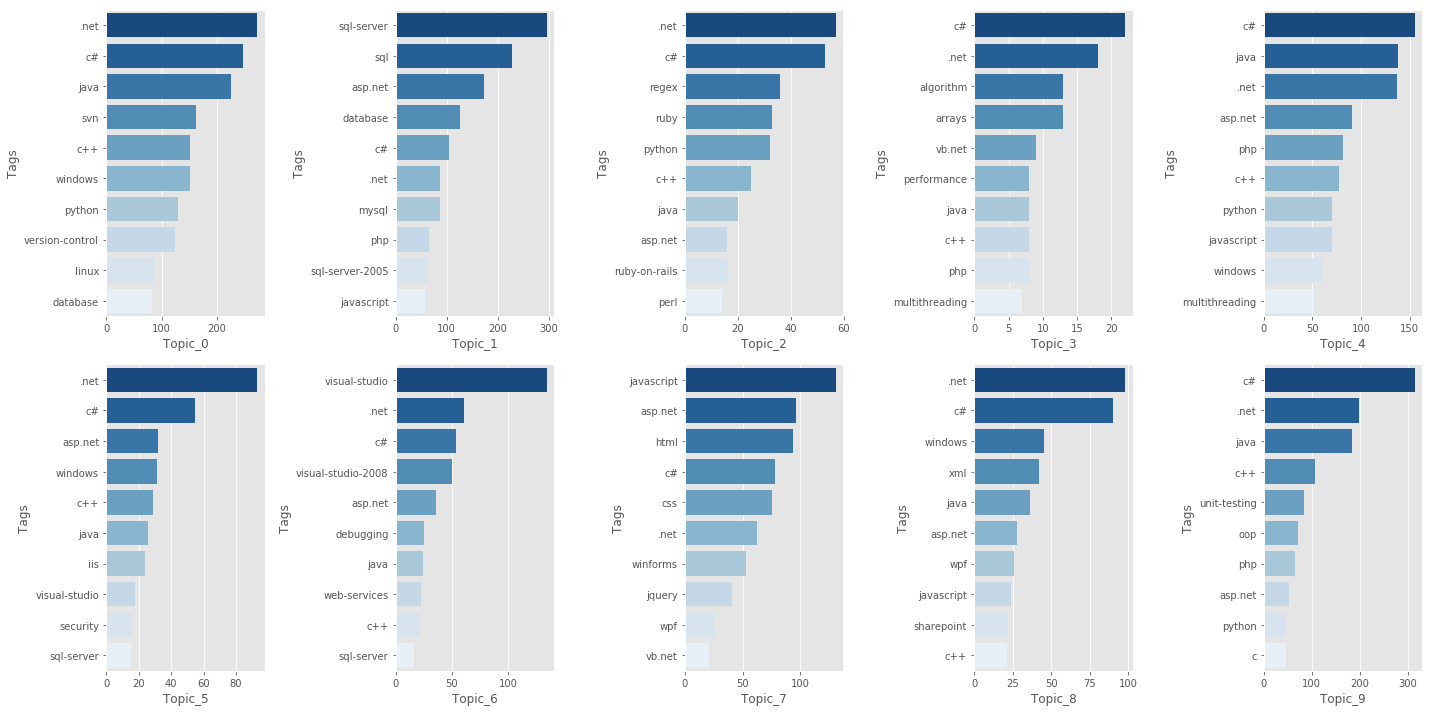

In [202]:
import seaborn as sns
Topics=[]
plt.figure(figsize=(20,10))
for topic in topic_tag.dominant_topic.unique():
    df=pd.DataFrame(topic_tag[topic_tag['dominant_topic']==topic].drop(['dominant_topic'],
                                                            axis=1).iloc[0].sort_values(ascending=False).head(10)).reset_index()
    df.rename(columns={'index':'Tags',topic:'Nber'},inplace=True)
    Topic='Topic_'+str(topic)
    Topics.append(Topic)
    i=len(Topics)
    plt.subplot(2, 5,i)
    plt.style.use ("ggplot")
    color_pal = sns.color_palette("Blues", len(df.index))
    color_pal = color_pal[::-1]
    sns.barplot(x="Nber", y="Tags", data=df, palette=color_pal)
    plt.xlabel(Topic)
plt.tight_layout()    
plt.show()

In [122]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_/best_lda_model.components_.sum(axis=1)[:, np.newaxis])
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,abc,ability,able,abort,absolute,absolutely,abstract,abstraction,accept,acceptable,...,yield,youd,youll,youre,youve,yui,zend,zero,zip,zone
Topic0,0.000002,0.000734,0.004225,0.000002,0.000002,0.000002,0.000002,0.000002,0.000203,0.000002,...,0.000002,0.000002,0.000197,0.000622,0.000542,0.000002,0.000002,0.000002,0.000002,0.000002
Topic1,0.000003,0.000516,0.001664,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000427,...,0.000003,0.000003,0.000003,0.000004,0.000003,0.000372,0.000003,0.000125,0.000003,0.000003
Topic2,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000185,0.000006,0.000320,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic3,0.000009,0.000009,0.000559,0.000009,0.002092,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009
Topic4,0.000333,0.000002,0.005222,0.000002,0.000363,0.000339,0.000002,0.000002,0.000681,0.000002,...,0.000278,0.000221,0.000003,0.000332,0.000002,0.000002,0.000002,0.000002,0.000002,0.000490
Topic5,0.000004,0.000004,0.002932,0.001115,0.000004,0.000004,0.000004,0.000637,0.000004,0.000221,...,0.000004,0.000062,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.002989,0.000004
Topic6,0.000005,0.000005,0.000005,0.000005,0.000005,0.000225,0.000005,0.000005,0.000005,0.000005,...,0.000005,0.000395,0.000005,0.000005,0.000005,0.000005,0.001384,0.000005,0.000005,0.000005
Topic7,0.000004,0.000004,0.002146,0.000004,0.000004,0.000521,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000202,0.000004,0.000004,0.000392,0.000004,0.000004,0.000004,0.000004
Topic8,0.000004,0.000004,0.003058,0.000004,0.000004,0.000004,0.000004,0.000004,0.000117,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
Topic9,0.000002,0.000139,0.001472,0.000002,0.000002,0.000002,0.001801,0.000002,0.000482,0.000002,...,0.000002,0.000002,0.000078,0.000459,0.000124,0.000002,0.000002,0.000795,0.000002,0.000002


In [123]:
df_topic_keywords=df_topic_keywords.reset_index(drop=True)
df_topic_keywords['dominant_topic']=range(0,10)
df_topic_keywords.head()

,abc,ability,able,abort,absolute,absolutely,abstract,abstraction,accept,acceptable,...,youd,youll,youre,youve,yui,zend,zero,zip,zone,dominant_topic
0,0.000002,0.000734,0.004225,0.000002,0.000002,0.000002,0.000002,0.000002,0.000203,0.000002,...,0.000002,0.000197,0.000622,0.000542,0.000002,0.000002,0.000002,0.000002,0.000002,0
1,0.000003,0.000516,0.001664,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000427,...,0.000003,0.000003,0.000004,0.000003,0.000372,0.000003,0.000125,0.000003,0.000003,1
2,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000185,0.000006,0.000320,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,2
3,0.000009,0.000009,0.000559,0.000009,0.002092,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,3
4,0.000333,0.000002,0.005222,0.000002,0.000363,0.000339,0.000002,0.000002,0.000681,0.000002,...,0.000221,0.000003,0.000332,0.000002,0.000002,0.000002,0.000002,0.000002,0.000490,4


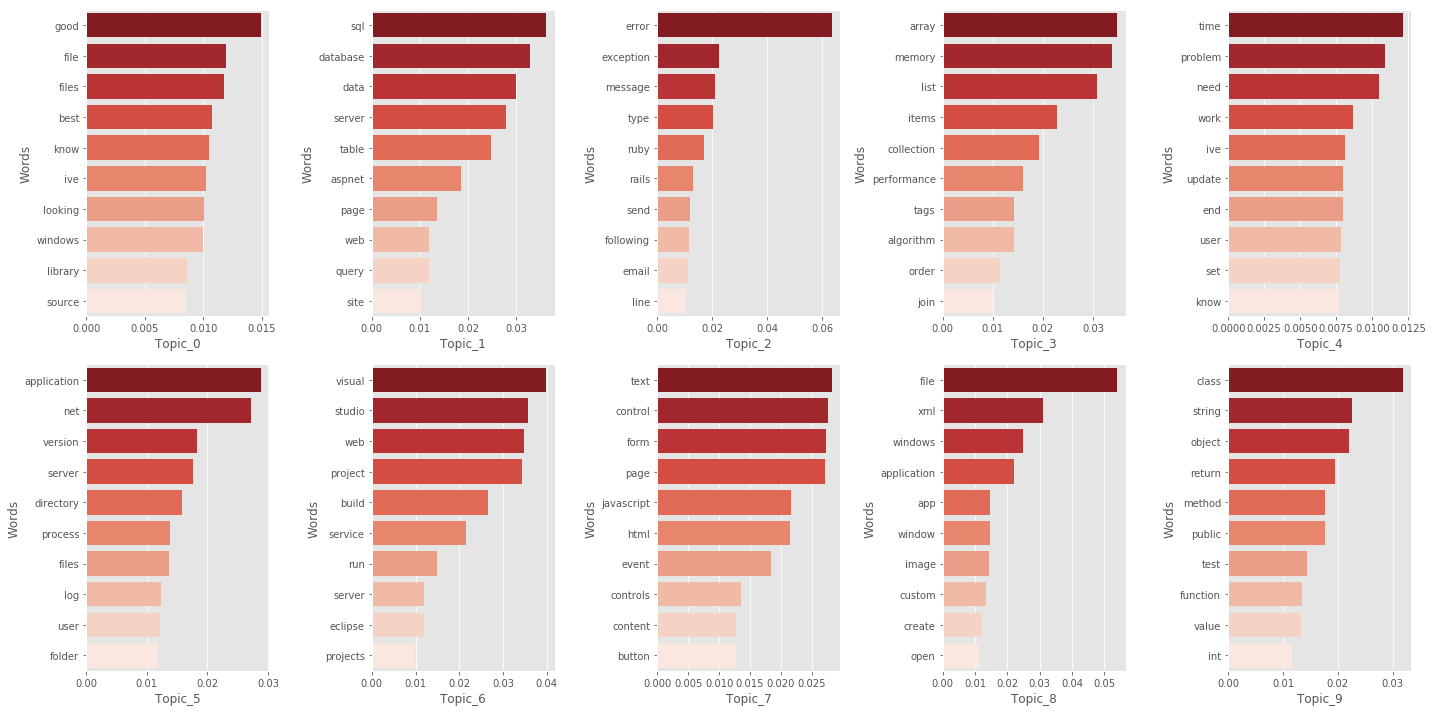

In [200]:
Topics=[]
plt.figure(figsize=(20,10))
for topic in df_topic_keywords.dominant_topic.unique():
    df=pd.DataFrame(df_topic_keywords[df_topic_keywords['dominant_topic']==topic].drop(['dominant_topic'],
                                                                                       axis=1).iloc[0].sort_values(ascending=False).head(10)).reset_index()
    df.rename(columns={'index':'Words',topic:'Nber'},inplace=True)
    Topic='Topic_'+str(topic)
    Topics.append(Topic)
    i=len(Topics)
    plt.subplot(2, 5,i)
    plt.style.use ("ggplot")
    color_pal = sns.color_palette("Reds", len(df.index))
    color_pal = color_pal[::-1]
    sns.barplot(x="Nber", y="Words", data=df, palette=color_pal)
    plt.xlabel(Topic)
plt.tight_layout()  
plt.show()

<span id="comparison"></span>
## 4. Comparison between Supervised and unsupervised Machine learning models

In [163]:
from sklearn.externals import joblib
linear_SVC = joblib.load('linearSVC_1.pkl')

In [164]:
#Map only tags used for the supervised model
tic()
y_test_add=y_test.reset_index()
y_test_add['Select_tags']='Select_tags'
for i in range(0,y_test_add.shape[0]):
    tag=[]
    for tags in df_tags.columns:
        if y_test_add[tags][i]==1:
            tag.append(tags)
    y_test_add['Select_tags'][i]=" ".join(x for x in tag)
tac()

Time passed: 0hour:2min:28sec


In [165]:
def predict_SU_S(text):
    text=[clean_p(text)]
    predict=linear_SVC.predict(text)
    tags=[]
    for i in range(0,len(df_tags.columns)):
        if predict.tolist()[0][i]==1:
            tags.append(df_tags.columns[i])
    tags_=" ".join(x for x in tags)
    return tags_

In [167]:
def clean_p(text):
    text = " ".join(x.lower() for x in text.split() ) 
    text=re.sub('[^\w\s]', "", text)
    text=re.sub(re.escape('?'), "", text)
    stop = stopwords.words('english')
    text = " ".join(x for x in text.split() if x not in stop)
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    return(text)

In [168]:
#Predict tags on test dataset using supervised models
tic()
x_test_add=x_test.reset_index()
y_test_add['predict_tags_S']="predict"
for i in range(0,x_test_add.shape[0]):
    y_test_add['predict_tags_S'][i]=predict_SU_S(x_test_add['clean_body'][i])
y_test_add.head()
tac()

Time passed: 0hour:2min:42sec


In [169]:
# Count number of tags predicted on the supervised model
y_test_add['tags_count_r'] = y_test_add['Select_tags'].apply(lambda x: len(str(x).split(" "))) #Number of original tags
y_test_add['tags_count_s'] = y_test_add['predict_tags_S'].apply(lambda x: len(str(x).split(" ")))
y_test_add.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,web-services,winapi,windows,winforms,wpf,xml,Select_tags,predict_tags_S,tags_count_r,tags_count_s
0,6252,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,web-services,.net c# string xml,1,4
1,4684,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,database,database,1,1
2,1731,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,.net,.net,1,1
3,4742,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,asp.net excel,asp.net c# excel,2,3
4,4521,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,apache,apache,1,1


In [170]:
#Count the right tags predicted using supervised model
tic()
y_test_add['tags_count_rs']=100
for i in range(0,y_test_add.shape[0]):
    y_test_add['tags_count_rs'][i]=len([x for x in y_test_add['Select_tags'][i].split() if x in y_test_add['predict_tags_S'][i].split()])
tac()

Time passed: 0hour:2min:25sec


In [171]:
#Map the questions with all original tags predicted using supervised model
tic()
y_test_add['tags_count_rsp']=0
for i in range(0,y_test_add.shape[0]):
    if y_test_add['tags_count_rs'][i]==y_test_add['tags_count_r'][i]:
        y_test_add['tags_count_rsp'][i]=1
tac()

Time passed: 0hour:1min:9sec


In [175]:
def clean(text):
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = " ".join(w for w in words if not w in stops)
    return(meaningful_words)

In [184]:
def predict_US(text):
    global sent_to_words
    global lemmatization
    
    text=text.lower()
    text = " ".join(x for x in text.split() if x not in most_freq_w)
    text = " ".join(x for x in text.split() if x not in less_feq_w)
    text_=[clean(clean_p(text))]

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text_))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = int(df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].dominant_topic)
    df=pd.DataFrame(topic_tag[topic_tag['dominant_topic']==topic].drop(['dominant_topic'],
                                                                       axis=1).iloc[0].sort_values(ascending=False)).reset_index()
    df.rename(columns={'index':'Tags',topic:'Nber'},inplace=True)
    df=df[df['Nber']>0]
    tags=df.Tags.tolist()
    tags_pred=" ".join(x for x in tags if x in text.split())
    if tags_pred=="":
        tags_pred=" ".join(x for x in tags[0:5])
    return tags_pred

In [185]:
#Predict tags on test dataset using unsupervised models
tic()
d=data_df.iloc[x_test_add['index'].tolist()][['Title_body']]
d=d.reset_index()
y_test_add['predict_tags_U']="predict_U"
for i in range(0,d.shape[0]):
    y_test_add['predict_tags_U'][i]=predict_US(d['Title_body'][i])
tac()

Time passed: 0hour:2min:44sec


In [186]:
y_test_add.head()

,index,.net,actionscript-3,ajax,algorithm,apache,arrays,asp.net,asp.net-mvc,c,...,winforms,wpf,xml,Select_tags,predict_tags_S,tags_count_r,tags_count_s,tags_count_rs,tags_count_rsp,predict_tags_U
0,6252,0,0,0,0,0,0,0,0,0,...,0,0,0,web-services,.net c# string xml,1,4,0,0,string xml wcf
1,4684,0,0,0,0,0,0,0,0,0,...,0,0,0,database,database,1,1,1,1,database
2,1731,1,0,0,0,0,0,0,0,0,...,0,0,0,.net,.net,1,1,1,1,.net c# windows xml java
3,4742,0,0,0,0,0,0,1,0,0,...,0,0,0,asp.net excel,asp.net c# excel,2,3,2,1,c# asp.net
4,4521,0,0,0,0,1,0,0,0,0,...,0,0,0,apache,apache,1,1,1,1,apache


In [187]:
#Count the right tags predicted using unsupervised model
tic()
y_test_add['tags_count_ru']=100
for i in range(0,y_test_add.shape[0]):
    y_test_add['tags_count_ru'][i]=len([x for x in y_test_add['Select_tags'][i].split() if x in y_test_add['predict_tags_U'][i].split()])
tac()

Time passed: 0hour:2min:32sec


In [188]:
#Map the questions with all original tags predicted using unsupervised model
tic()
y_test_add['tags_count_rup']=0
for i in range(0,y_test_add.shape[0]):
    if y_test_add['tags_count_ru'][i]==y_test_add['tags_count_r'][i]:
        y_test_add['tags_count_rup'][i]=1
tac()

Time passed: 0hour:1min:3sec


In [190]:
y_test_add['tags_count_u'] = y_test_add['predict_tags_U'].apply(lambda x: len(str(x).split(" ")))

In [191]:
n0=y_test_add.tags_count_r.sum() # Total tags to predict
n1=y_test_add.shape[0] # Total questions to predict tags

s0=y_test_add.tags_count_s.sum() # Total tags predicted using supervised model
s1=y_test_add.tags_count_rs.sum() # Total tags well predicted using supervised model
s2=y_test_add.tags_count_rsp.sum() # Total Questions well predicted (at the exact tags) using supervised model
s3=y_test_add[y_test_add['tags_count_rs']>0].shape[0] #Questions with at least one tag well predicted unsupervised

u0=y_test_add.tags_count_u.sum() # Total tags predicted using unsupervised model
u1=y_test_add.tags_count_ru.sum() # Total tags well predicted using unsupervised model
u2=y_test_add.tags_count_rup.sum() # Total Questions well predicted (at the exact tags) using unsupervised model
u3=y_test_add[y_test_add['tags_count_ru']>0].shape[0] #Questions with at least one tag well predicted unsupervised

tab=pd.DataFrame({'Supervised':[n0,n1,s0,s1,s2,s3,round(s1/n0*100,0),round(s2/n1*100,0),round(s3/n1*100,0)],
                 'Unsupervised':[n0,n1,u0,u1,u2,u3,round(u1/n0*100,0),round(u2/n1*100,0),round(u3/n1*100,0)]},
                index=['Total tags to predict','Total questions','Total tags predicted',
                      'Total tags well predicted','Total Questions well predicted','Total Questions with at least one tag well predicted',
                      '(%)Total tags well predicted','(%)Total Questions well predicted', '(%)Total Questions with at least one tag well predicted'])
tab.Supervised=tab.Supervised.astype(int)
tab.Unsupervised=tab.Unsupervised.astype(int)
tab

,Supervised,Unsupervised
Total tags to predict,3182,3182
Total questions,2000,2000
Total tags predicted,2985,5044
Total tags well predicted,1767,1696
Total Questions well predicted,940,870
Total Questions with at least one tag well predicted,1395,1413
(%)Total tags well predicted,56,53
(%)Total Questions well predicted,47,44
(%)Total Questions with at least one tag well predicted,70,71
